In [1]:
# Dependencies 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
from sklearn.naive_bayes import GaussianNB
from scipy.special import comb
import multiprocessing as mp

In [2]:
# Some paths
rootPath = '/Users/frederictheunissen/Google Drive/My Drive/julie/'
pklPath = 'pkl/'

# Our color code for calls
callColor = {'Be': (0/255.0, 230/255.0, 255/255.0), 'LT': (0/255.0, 95/255.0, 255/255.0), 'Tu': (255/255.0, 200/255.0, 65/255.0), 'Th': (255/255.0, 150/255.0, 40/255.0), 
             'Di': (255/255.0, 105/255.0, 15/255.0), 'Ag': (255/255.0, 0/255.0, 0/255.0), 'Wh': (255/255.0, 180/255.0, 255/255.0), 'Ne': (255/255.0, 100/255.0, 255/255.0),
             'Te': (140/255.0, 100/255.0, 185/255.0), 'DC': (100/255.0, 50/255.0, 200/255.0), 'So': (0/255.0, 0/255.0, 0/255.0)}

# Call names are in alphabetical order (to check...)

callNames = ['Ag', 'Be', 'DC', 'Di', 'LT', 'Ne', 'So', 'Te', 'Th', 'Wh']

In [3]:


# First load the data

numUnits = [1, 2, 3, 5, 10, 20]
argList = []
pcc = []
confMat = []
selH = []

for nUnit in numUnits:
    inPath = rootPath+ pklPath + 'JulieDataBase%dGoodUnitPCPerZone.pkl' % nUnit
    fileIn = open(inPath,"rb")
    argList.append(pk.load(fileIn))
    confMat.append(pk.load(fileIn))
    pcc.append(pk.load(fileIn))
    selH.append(pk.load(fileIn))
    zoneUnique = pk.load(fileIn)
    fileIn.close()


In [4]:
def info_matrix(conf_matrix):

# Calculates the mutual information from a confusion matrix.
# This code assumes that the rows are the actual categories and that they are equally probable
# This mutual information is not corrected for low probabilities.

    ncat = conf_matrix.shape[0]
    prob_matrix = np.copy(conf_matrix)

    for i in range(ncat):
        if (np.sum(conf_matrix[i,:]) < 0.9999 or np.sum(conf_matrix[i,:]) >  1.0001):
            print('Error: Row', i, 'does not sum to 1')
            return 0.0
    
    prob_matrix /= ncat

        

    # Check for sum = 1
    sump = np.sum(prob_matrix)
    if ( sump < 0.9999 or sump > 1.0001):
        print('Error in info_matrix: input matrix sums to %f' % sump)
        return 0.0


    prob_matrix_for_entropy = np.copy(prob_matrix)
    prob_matrix_for_entropy[prob_matrix ==0] = 1    # Set 0 to 1 to insure that xlogx goes to zero as x goes to zero
    tot_ent = np.sum(-prob_matrix_for_entropy*np.log2(prob_matrix_for_entropy))

    row_prob = np.sum(prob_matrix, axis=0)
    row_prob[row_prob == 0] = 1  # Set 0 to 1 to insure that xlogx goes to zero as x goes to zero
    row_ent = np.sum(-row_prob*np.log2(row_prob))

    col_prob = np.sum(prob_matrix, axis=1)
    col_prob[col_prob == 0] = 1  # Set 0 to 1 to insure that xlogx goes to zero as x goes to zero
    col_ent = np.sum(-col_prob*np.log2(col_prob));

    mi = row_ent + col_ent - tot_ent;

    return mi

In [5]:
# Load up data base to recalculate max values or read the data

# Load the data base
outPath = rootPath+'JulieDataBase.pkl'
fileIn = open(outPath,"rb")
dfDataBase = pk.load(fileIn)
pcKDE = pk.load(fileIn)
fileIn.close()

/Users/frederictheunissen/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
# Julie's data was ran without whines

dfDataBaseNW = dfDataBase[dfDataBase['call'] != 'Wh']
# Number of Calls
callNames = np.unique(dfDataBaseNW['call'])
ncalls = callNames.shape[0]

In [9]:

pccNorm = []
rate = []
for i, nUnit in enumerate(numUnits):
    pccNormUnit = []
    rateUnit = []
    for j, zone in enumerate(zoneUnique):
        # Number of ensembles
        nEn = len(argList[i][j])
        nSpikes = np.zeros(nEn)
        for k, unitList in enumerate(argList[i][j]):
            ensembleRate = 0
            for l, unit in enumerate(unitList):
            
                # Calculate the average response:
                unitIndex = dfDataBaseNW.index[dfDataBaseNW['site']+'_'+ dfDataBaseNW['unit'] == unit]
                rvals = dfDataBaseNW['R'][unitIndex].array
                rMean = np.mean(rvals)
                ensembleRate += rMean
            nSpikes[k] = ensembleRate
        pccNormUnit.append(pcc[i][j]/nSpikes)
        rateUnit.append(nSpikes)
    pccNorm.append(pccNormUnit)
    rate.append(rateUnit)
            


In [7]:
# Or Read previous calculation
inPath = rootPath+'pccUnitRateArea.pkl'
fileIn = open(inPath,"rb")
argList = pk.load(fileIn)
pcc = pk.load(fileIn)
selH = pk.load(fileIn)
rate = pk.load(fileIn)
pccNorm = pk.load(fileIn)


fileIn.close()

L
Average Rate 88.9228414294664
Average PCC 59.63072750600447
Average Eff 0.6971717815443357 0.6971717815443357
Avg pCC/ Avg Rate 0.6705895419829062


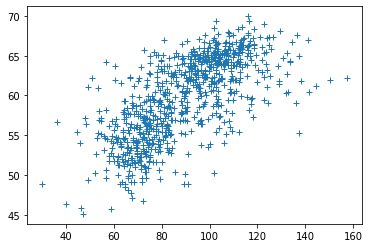

In [8]:
plt.plot(rate[5][0],pcc[5][0], '+')
print(zoneUnique[0])
print('Average Rate', np.mean(rate[5][0]))
print('Average PCC', np.mean(pcc[5][0]))
print('Average Eff', np.mean(pcc[5][0]/rate[5][0]), np.mean(pccNorm[5][0]))
print('Avg pCC/ Avg Rate', np.mean(pcc[5][0])/np.mean(rate[5][0]))

NCM-CMM
Average Rate 76.19289921971826
Average PCC 58.585767227123505
Average Eff 0.8046503711031212 0.8046503711031212
Avg pCC/ Avg Rate 0.7689137416621872


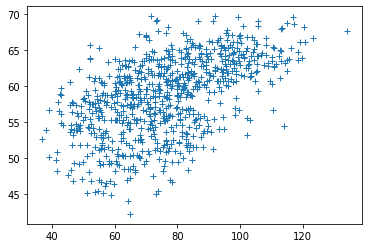

In [9]:
plt.plot(rate[5][1], pcc[5][1], '+')
print(zoneUnique[1])
print('Average Rate', np.mean(rate[5][1]))
print('Average PCC', np.mean(pcc[5][1]))
print('Average Eff', np.mean(pcc[5][1]/rate[5][1]), np.mean(pccNorm[5][1]))
print('Avg pCC/ Avg Rate', np.mean(pcc[5][1])/np.mean(rate[5][1]))

In [10]:
breakflg = False
unitNumber = np.zeros((len(numUnits), len(zoneUnique)))
for i, nUnit in enumerate(numUnits):

    for j, zone in enumerate(zoneUnique):
        # Number of ensembles
        nEn = len(argList[i][j])
        unitNumber[i][j] = np.unique(argList[i][j]).shape[0]
        print(i, j, 'nEn', nEn, 'pcc',pcc[i][j].shape[0], 'nUnits', unitNumber[i][j] )


0 0 nEn 166 pcc 166 nUnits 166.0
0 1 nEn 209 pcc 209 nUnits 209.0
1 0 nEn 2001 pcc 2001 nUnits 161.0
1 1 nEn 2001 pcc 2001 nUnits 203.0
2 0 nEn 2001 pcc 2001 nUnits 166.0
2 1 nEn 2001 pcc 2001 nUnits 209.0
3 0 nEn 2001 pcc 2001 nUnits 166.0
3 1 nEn 2001 pcc 2001 nUnits 209.0
4 0 nEn 1001 pcc 1001 nUnits 161.0
4 1 nEn 1001 pcc 1001 nUnits 194.0
5 0 nEn 801 pcc 801 nUnits 149.0
5 1 nEn 801 pcc 801 nUnits 194.0


In [11]:
# Calculate the Mean and Max of the pcc normalized by Rate
topPercent = 5

pccNormMean = np.zeros((len(numUnits), len(zoneUnique)))
pccNormMax = np.zeros((len(numUnits), len(zoneUnique)))
pccNormSD = np.zeros((len(numUnits), len(zoneUnique)))
for i, nUnit in enumerate(numUnits):
    for j, zone in enumerate(zoneUnique):

        pccNormMean[i][j] = np.mean(pccNorm[i][j])
        
        fac = np.sqrt(unitNumber[i][j]/(unitNumber[i][j]-nUnit))
        pccNormSD[i][j] =  np.std(pccNorm[i][j])*fac
        
        # Max values (averaged over the topPercent)
        indSort = np.argsort(pccNorm[i][j])
        ls = len(indSort)
        ns = int(ls*topPercent/100.0)
        indGood = indSort[-ns-1:-1]
        pccNormMax[i][j] = np.mean(pccNorm[i][j][indGood])
    

In [12]:
# Calculate the Mean and Max of the pcc
pccMean = np.zeros((len(numUnits), len(zoneUnique)))
pccMax = np.zeros((len(numUnits), len(zoneUnique)))
pccSD = np.zeros((len(numUnits), len(zoneUnique)))

for i, nUnit in enumerate(numUnits):
    for j, zone in enumerate(zoneUnique):

        pccMean[i][j] = np.mean(pcc[i][j])
        
        fac = np.sqrt(unitNumber[i][j]/(unitNumber[i][j]-nUnit))
        pccSD[i][j] =  np.std(pcc[i][j])*fac

        # Max values (averaged over the topPercent)
        indSort = np.argsort(pcc[i][j])
        ls = len(indSort)
        ns = int(ls*topPercent/100.0)
        indGood = indSort[-ns-1:-1]
        pccMax[i][j] = np.mean(pcc[i][j][indGood])

In [13]:
# Calculate the average rate
rateMean = np.zeros((len(numUnits), len(zoneUnique)))
rateMax = np.zeros((len(numUnits), len(zoneUnique)))
rateMin = np.zeros((len(numUnits), len(zoneUnique)))
rateSD = np.zeros((len(numUnits), len(zoneUnique)))

for i, nUnit in enumerate(numUnits):
    for j, zone in enumerate(zoneUnique):

        rateMean[i][j] = np.mean(rate[i][j])
        
        fac = np.sqrt(unitNumber[i][j]/(unitNumber[i][j]-nUnit))
        rateSD[i][j] =  np.std(rate[i][j])*fac
 
        # Max values (averaged over the topPercent)
        indSort = np.argsort(rate[i][j])
        ls = len(indSort)
        ns = int(ls*topPercent/100.0)
        indGood = indSort[-ns-1:-1]
        rateMax[i][j] = np.mean(rate[i][j][indGood])
        indGood = indSort[0:ns]
        rateMin[i][j] = np.mean(rate[i][j][indGood])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


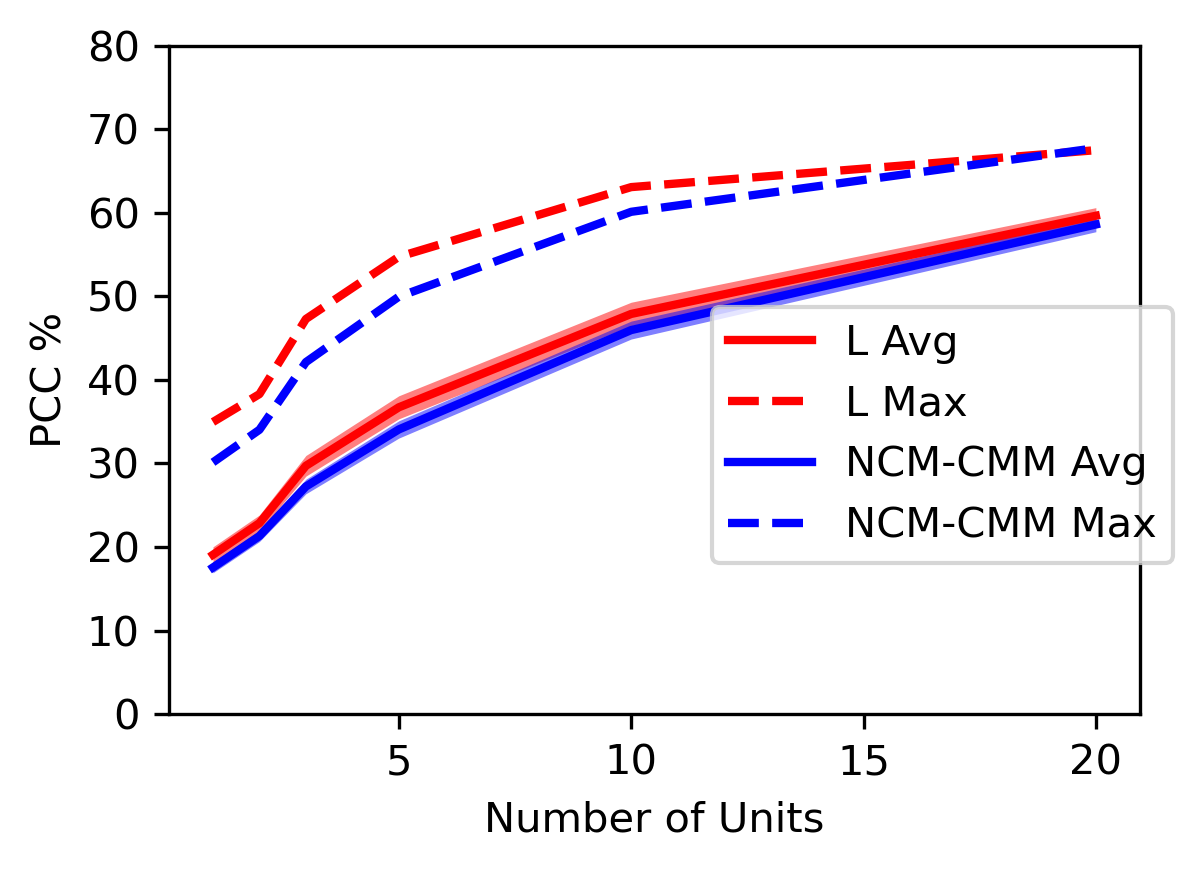

In [14]:
# Make plot of mean values
fig, ax1 = plt.subplots(figsize=(4, 3), dpi =300)
colorName = ['red', 'blue']

ax1.set_xlabel('Number of Units')
ax1.set_ylabel('PCC %')

for izone, zone in enumerate(zoneUnique):
    ax1.plot(numUnits, pccMean[:,izone], color=colorName[izone], linestyle='-', linewidth=2, label=zone +' Avg')
    ax1.fill_between(numUnits, pccMean[:,izone] + 2*pccSD[:,izone]/np.sqrt(unitNumber[:,izone]-numUnits),
                               pccMean[:,izone] - 2*pccSD[:,izone]/np.sqrt(unitNumber[:,izone]-numUnits), 
                               alpha=0.5, linewidth=0, color = colorName[izone] )
    ax1.plot(numUnits, pccMax[:,izone], color=colorName[izone], linestyle='--', linewidth=2, label=zone +' Max')


ax1.set_ylim((0,80))



fig.tight_layout()
fig.legend(loc='center right')

plt.savefig('/Users/frederictheunissen/Desktop/PCCvsUnitsvsAreaJulie.eps')

In [17]:
# Perform the statistical analysis for 20 units
from scipy.stats import t as tdist

nE = numUnits[5]
diffMean = pccMean[5,0] - pccMean[5,1]
# I am going to use the equal variance assumption
n0 = unitNumber[5][0]-nE+1
n1 = unitNumber[5][1]-nE+1
df = (n0 + n1 - 2)
pooledSD = np.sqrt( (pccSD[5,0]**2*(n0-1) + pccSD[5,1]**2*(n1-1)) / df)

tval = diffMean/(pooledSD*np.sqrt(1/n0 + 1/n1))
dval = diffMean/pooledSD

# Two tail t-test
pval = 2*(1 - tdist.cdf(abs(tval), df))

print('PCC d=', dval, 't(', df, ')=', tval, 'p=', pval)


PCC d= 0.18598609752422546 t( 303.0 )= 1.606280039836075 p= 0.10925400171322708


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


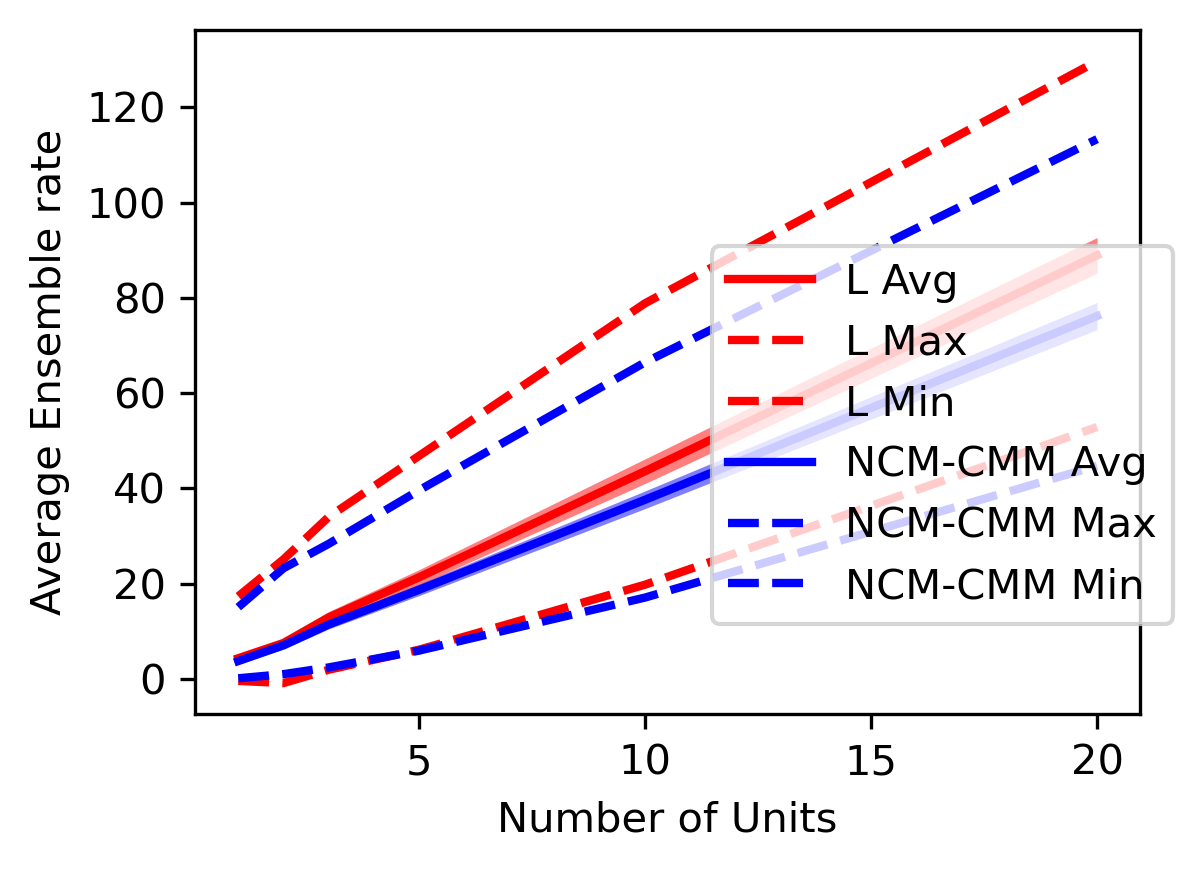

In [18]:
# Make plot of mean values
fig, ax1 = plt.subplots(figsize=(4, 3), dpi =300)

ax1.set_xlabel('Number of Units')
ax1.set_ylabel('Average Ensemble rate')
for izone, zone in enumerate(zoneUnique):
    ax1.plot(numUnits, rateMean[:,izone], color=colorName[izone], linestyle='-', linewidth=2, label=zone +' Avg')
    ax1.fill_between(numUnits, rateMean[:,izone] + 2*rateSD[:,izone]/np.sqrt(unitNumber[:,izone]-numUnits),
                               rateMean[:,izone] - 2*rateSD[:,izone]/np.sqrt(unitNumber[:,izone]-numUnits), 
                               alpha=0.5, linewidth=0, color = colorName[izone] )
    ax1.plot(numUnits, rateMax[:,izone], color=colorName[izone], linestyle='--', linewidth=2, label=zone +' Max')
    ax1.plot(numUnits, rateMin[:,izone], color=colorName[izone], linestyle='--', linewidth=2, label=zone +' Min')



fig.tight_layout()
fig.legend(loc='center right')

plt.savefig('/Users/frederictheunissen/Desktop/RatevsUnitsvsAreaJulie.eps')

In [19]:
# Perform the statistical analysis for 20 units
from scipy.stats import t as tdist

diffMean = rateMean[5,0] - rateMean[5,1]
# I am going to use the equal variance assumption
nE = numUnits[5]
n0 = unitNumber[5][0]-nE+1
n1 = unitNumber[5][1]-nE+1
df = (n0 + n1 - 2)
pooledSD = np.sqrt( (rateSD[5,0]**2*(n0-1) + rateSD[5,1]**2*(n1-1)) / df)

tval = diffMean/(pooledSD*np.sqrt(1/n0 + 1/n1))
dval = diffMean/pooledSD

# Two tail t-test
pval = 2*(1 - tdist.cdf(abs(tval), df))

print('Rate d=', dval, 't(', df, ')=', tval, 'p=', pval)


Rate d= 0.6407780197634628 t( 303.0 )= 5.534117640043872 p= 6.775418404103561e-08


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


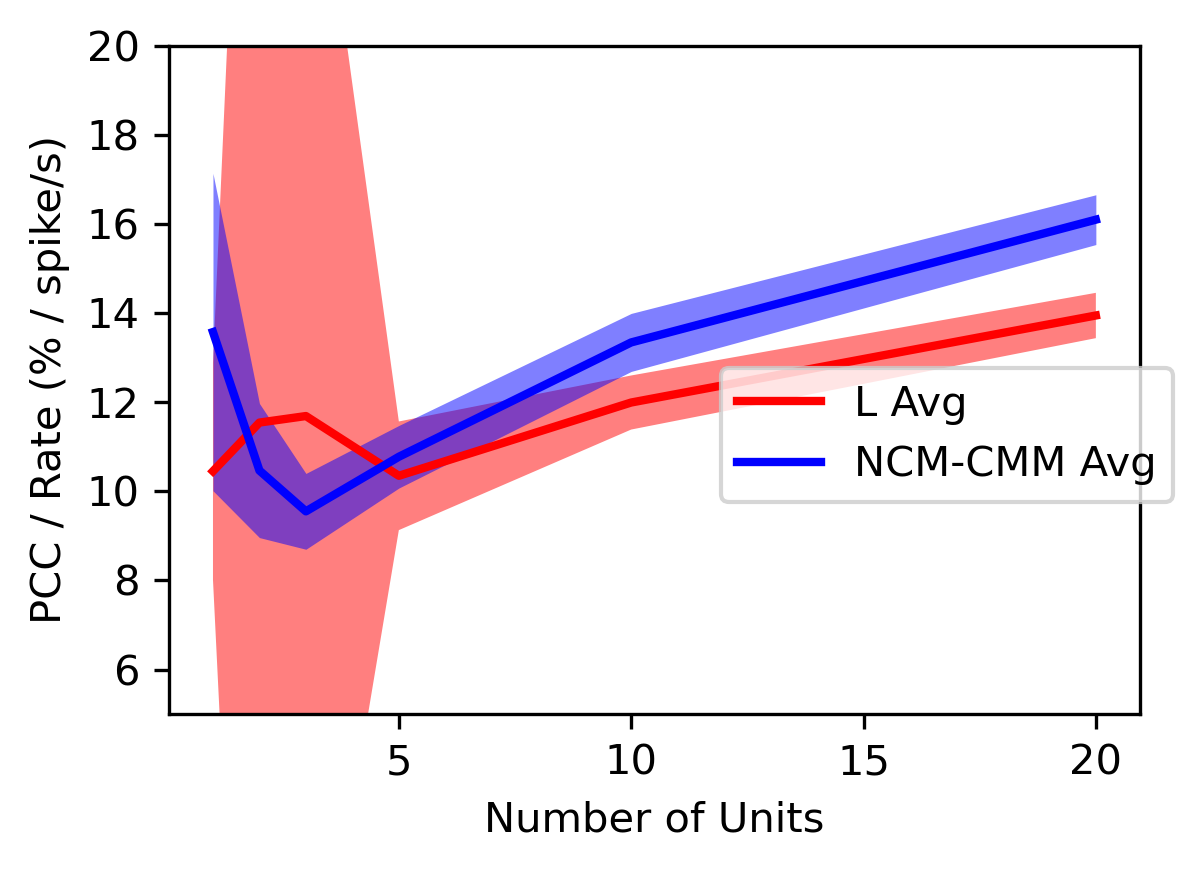

In [20]:
# Make plot of mean values
fig, ax1 = plt.subplots(figsize=(4, 3), dpi =300)

ax1.set_xlabel('Number of Units')
ax1.set_ylabel('PCC / Rate (% / spike/s)')

for izone, zone in enumerate(zoneUnique):
    ax1.plot(numUnits, pccNormMean[:,izone]*numUnits, color=colorName[izone], linestyle='-', linewidth=2, label=zone +' Avg')
    ax1.fill_between(numUnits, pccNormMean[:,izone]*numUnits + 2*pccNormSD[:,izone]*numUnits/np.sqrt(unitNumber[:,izone]-numUnits),
                               pccNormMean[:,izone]*numUnits - 2*pccNormSD[:,izone]*numUnits/np.sqrt(unitNumber[:,izone]-numUnits), 
                               alpha=0.5, linewidth=0, color = colorName[izone] )



ax1.set_ylim((5,20))
fig.tight_layout()
fig.legend(loc='center right')

plt.savefig('/Users/frederictheunissen/Desktop/PCCNormvsUnitsvsAreaJulie.eps')

In [21]:
# Perform the statistical analysis for 20 units
from scipy.stats import t as tdist

diffMean = pccNormMean[5,0] - pccNormMean[5,1]
# I am going to use the equal variance assumption
nE = numUnits[5]
n0 = unitNumber[5][0]-nE+1
n1 = unitNumber[5][1]-nE+1
df = (n0 + n1 - 2)
pooledSD = np.sqrt( (pccNormSD[5,0]**2*(n0-1) + pccNormSD[5,1]**2*(n1-1)) / df)

tval = diffMean/(pooledSD*np.sqrt(1/n0 + 1/n1))
dval = diffMean/pooledSD

# Two tail t-test
pval = 2*(1 - tdist.cdf(abs(tval), df))

print('PCC Norm d=', dval, 't(', df, ')=', tval, 'p=', pval)


PCC Norm d= -0.6384799435541814 t( 303.0 )= -5.514270167603036 p= 7.508015742452301e-08


In [26]:
# Save data

outPath = rootPath+'pccUnitRateArea.pkl'
fileOut = open(outPath,"wb")
pk.dump(argList, fileOut)
pk.dump(pcc, fileOut)
pk.dump(selH, fileOut)
pk.dump(rate, fileOut)
pk.dump(pccNorm, fileOut)


fileOut.close()